In [21]:
import xlrd
import numpy as np 
import pandas as pd 
import geopandas as gpd 
from shapely.wkt import loads
from shapely.ops import substring
import matplotlib.pyplot as plt 

%matplotlib inline
!which python

/home/bingyu/anaconda3/envs/geo/bin/python


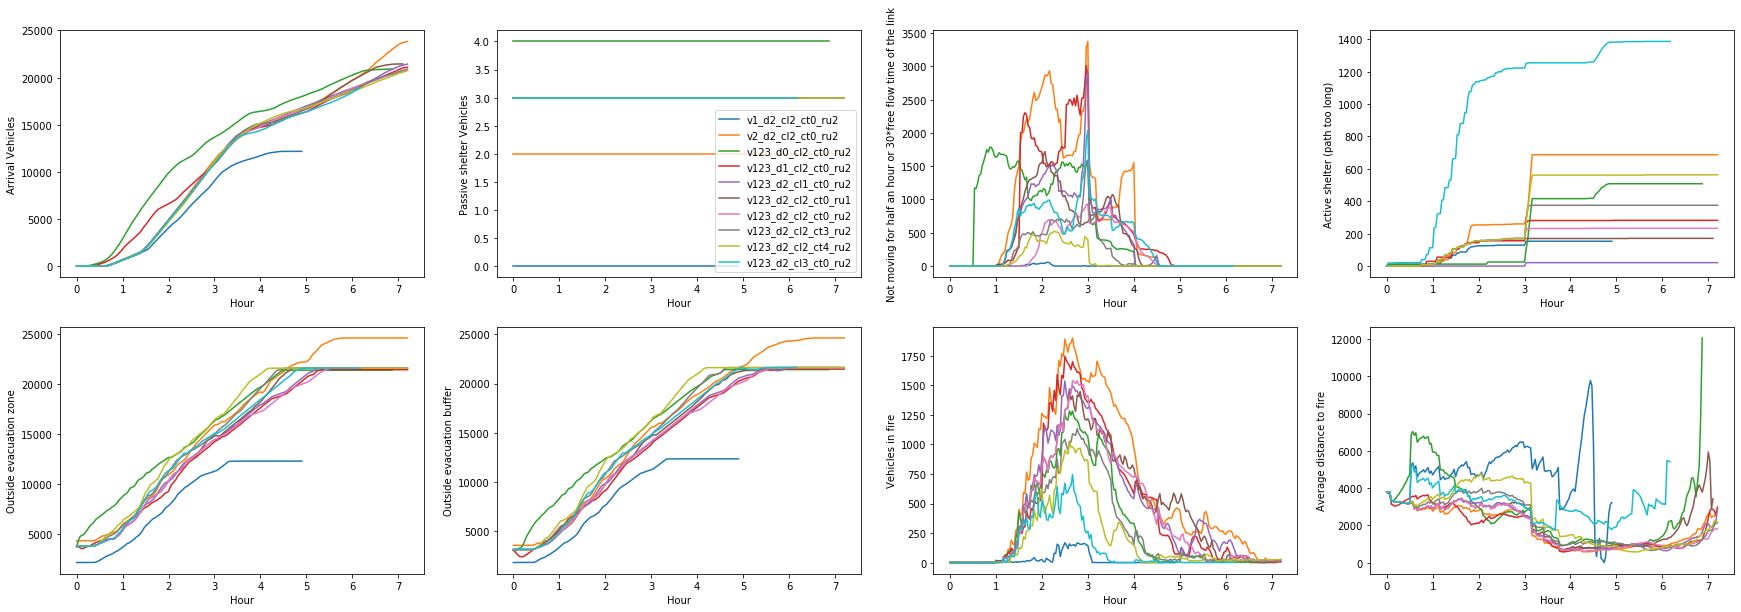

In [37]:
fig, ax = plt.subplots(2,4,figsize=(30, 10))
for vphh_id in ['1', '2', '123']:
    for dept_id in ['0', '1', '2']:
        for clos_id in ['1', '2', '3']:
            for contra_id in ['0', '3', '4']:
                for rout_id in ['1', '2']:
                    scen_nm = "v{}_d{}_cl{}_ct{}_ru{}".format(vphh_id, dept_id, clos_id, contra_id, rout_id)
                    try:
                        t_stats = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
                    except FileNotFoundError:
                        continue

                    t_stats = t_stats.loc[t_stats['t']<=26000]
                    arrival_curve = ax[0,0].plot(t_stats['t']/3600, t_stats['arr'], label=scen_nm)
                    # if np.max(t_stats['passive_shelter'])>1:
                    shelter_curve = ax[0,1].plot(t_stats['t']/3600, t_stats['passive_shelter'], color=ax[0,0].get_lines()[-1].get_c(), label=scen_nm)
                    # if np.max(t_stats['congested'])>1:
                    shelter_curve = ax[0,2].plot(t_stats['t']/3600, t_stats['congested'], color=ax[0,0].get_lines()[-1].get_c(), label=scen_nm)

                    # if np.max(t_stats['active2_shelter'])>1:
                    shelter_curve = ax[0,3].plot(t_stats['t']/3600, t_stats['active2_shelter'],  color=ax[0,0].get_lines()[-1].get_c(), label=scen_nm)
                    outside_curve = ax[1,0].plot(t_stats['t']/3600, t_stats['out_evac_zone_cnts']+t_stats['arr']+t_stats['passive_shelter']+t_stats['active1_shelter']+t_stats['active2_shelter'], color=ax[0,0].get_lines()[-1].get_c(), label=scen_nm)
                    outside_buffer_curve = ax[1,1].plot(t_stats['t']/3600, t_stats['out_evac_buffer_cnts']+t_stats['arr']+t_stats['passive_shelter']+t_stats['active1_shelter']+t_stats['active2_shelter'], color=ax[0,0].get_lines()[-1].get_c(), label=scen_nm)

                    in_fire_curve = ax[1,2].plot(t_stats['t']/3600, t_stats['in_fire_cnts'], color=ax[0,0].get_lines()[-1].get_c(), label=scen_nm)
                    fire_dist_curve = ax[1,3].plot(t_stats['t']/3600, t_stats['avg_fdist'], color=ax[0,0].get_lines()[-1].get_c(), label=scen_nm)

ax[0,0].set_xlabel('Hour')
ax[0,0].set_ylabel('Arrival Vehicles')
# ax[0,0].legend()
ax[0,1].set_xlabel('Hour')
ax[0,1].set_ylabel('Passive shelter Vehicles')
ax[0,1].legend()
ax[0,2].set_xlabel('Hour')
ax[0,2].set_ylabel('Not moving for half an hour or 30*free flow time of the link')
# ax[1,0].legend()
ax[0,3].set_xlabel('Hour')
ax[0,3].set_ylabel('Active shelter (path too long)')
# ax[1,1].legend()
ax[1,0].set_xlabel('Hour')
ax[1,0].set_ylabel('Outside evacuation zone')
# ax[2,0].legend()
ax[1,1].set_xlabel('Hour')
ax[1,1].set_ylabel('Outside evacuation buffer')
# ax[2,1].legend()
ax[1,2].set_xlabel('Hour')
ax[1,2].set_ylabel('Vehicles in fire')
# ax[3,0].legend()
ax[1,3].set_xlabel('Hour')
ax[1,3].set_ylabel('Average distance to fire')
# ax[3,1].legend()
# plt.show()
plt.savefig('metrics.png')

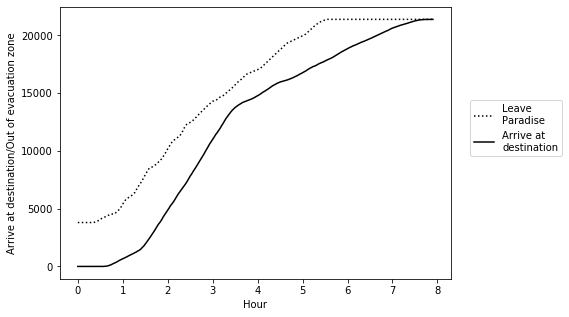

In [27]:
scen_nm_style = {"v123_d2_cl2_ct0_ru2": ('k', '-', 'Base case')}
for scen_nm, (c, ls, label) in scen_nm_style.items():
    t_stats = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
    # print(t_stats.loc[t_stats['t'].isin([3600*4, 3600*7])])
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.plot(t_stats['t']/3600, t_stats['out_evac_zone_cnts']+t_stats['arr'], c=c, ls=':', label='Leave\nParadise')
    ax.plot(t_stats['t']/3600, t_stats['arr'], c=c, ls='-', label='Arrive at\ndestination')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Arrive at destination/Out of evacuation zone')
plt.legend(loc=(1.05,0.45))

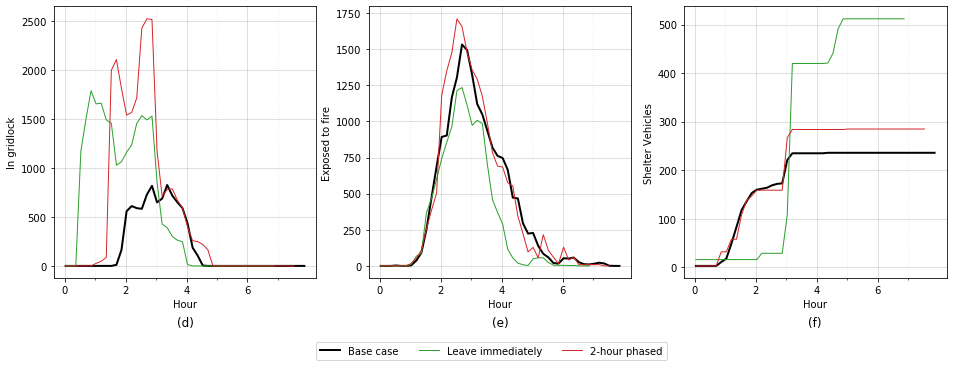

In [99]:
scen_nm_style = {"v123_d2_cl2_ct0_ru2": ('k', '-', 2, 'Base case'),
                # "v1_d2_cl2_ct0_ru2": ('C0', '-', 1, '1 veh/household'), "v2_d2_cl2_ct0_ru2": ('C1', '-', 1, ' 2 veh/household'),
                "v123_d0_cl2_ct0_ru2": ('C2', '-', 1, 'Leave immediately'), "v123_d1_cl2_ct0_ru2": ('C3', '-', 1, '2-hour phased'),
                # "v123_d2_cl1_ct0_ru2": ('C4', '-', 1, 'No fire closure'), "v123_d2_cl3_ct0_ru2": ('C5', '-', 1, '100% fire closure'),
                # "v123_d2_cl2_ct3_ru2": ('C6', '-', 1, 'Skyway 3-lane contraflow'), "v123_d2_cl2_ct4_ru2": ('C7', '-', 1, 'Skyway 4-lane contraflow'),
                # "v123_d2_cl2_ct0_ru1": ('C8', '-', 1, 'Cell tower working')
                }

fig, ax = plt.subplots(1,3,figsize=(16,5))
major_ticks = np.arange(0, 8, 2)
minor_ticks = np.arange(0, 8, 1)

for scen_nm, (c, ls, lw, label) in scen_nm_style.items():
    t_stats = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
    t_stats = t_stats.loc[t_stats['t']%600==120]
    # t_stats = t_stats.loc[~t_stats['t'].isin([10800,10680,10560])]
    # print(t_stats.sort_values(by='congested', ascending=False).head())
    ax[0].plot(t_stats['t']/3600, t_stats['congested'], c=c, ls=ls, lw=lw)
    ax[0].set_xlabel('Hour')
    ax[0].set_ylabel('In gridlock')
    ax[0].set_xticks(major_ticks)
    ax[0].set_xticks(minor_ticks, minor=True)
    ax[0].grid(which='minor', alpha=0.3, ls=':')
    ax[0].grid(which='major', alpha=0.5)
    ax[0].set_title("(d)", x=0.5, y=-0.2)

    ax[1].plot(t_stats['t']/3600, t_stats['in_fire_cnts'], c=c, ls=ls, lw=lw)
    ax[1].set_xlabel('Hour')
    ax[1].set_ylabel('Exposed to fire')
    ax[1].set_xticks(major_ticks)
    ax[1].set_xticks(minor_ticks, minor=True)
    ax[1].grid(which='minor', alpha=0.3, ls=':')
    ax[1].grid(which='major', alpha=0.5)
    ax[1].set_title("(e)", x=0.5, y=-0.2)

    ax[2].plot(t_stats['t']/3600, t_stats['active2_shelter']+t_stats['passive_shelter'], c=c, ls=ls, lw=lw, label=label)
    ax[2].set_xlabel('Hour')
    ax[2].set_ylabel('Shelter Vehicles')
    ax[2].set_xticks(major_ticks)
    ax[2].set_xticks(minor_ticks, minor=True)
    ax[2].grid(which='minor', alpha=0.3, ls=':')
    ax[2].grid(which='major', alpha=0.5)
    ax[2].set_title("(f)", x=0.5, y=-0.2)
plt.legend(loc=(-1.4,-0.3), ncol=3)

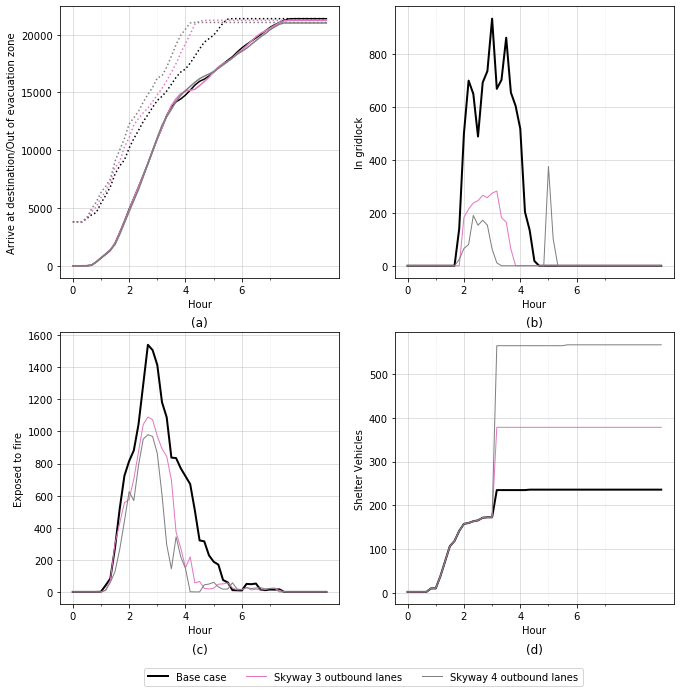

In [119]:
scen_nm_style = {"v123_d2_cl2_ct0_ru2": ('k', '-', 2, 'Base case'),
                # "v1_d2_cl2_ct0_ru2": ('C0', '-', 1, '1 veh/household'), "v2_d2_cl2_ct0_ru2": ('C1', '-', 1, ' 2 veh/household'),
                # "v123_d0_cl2_ct0_ru2": ('C2', '-', 1, 'Leave immediately'), "v123_d1_cl2_ct0_ru2": ('C3', '-', 1, '2-hour phased'),
                # "v123_d2_cl1_ct0_ru2": ('C4', '-', 1, 'No fire closure'), "v123_d2_cl3_ct0_ru2": ('C9', '-', 1, '100% fire closure'),
                "v123_d2_cl2_ct3_ru2": ('C6', '-', 1, 'Skyway 3 outbound lanes'), "v123_d2_cl2_ct4_ru2": ('C7', '-', 1, 'Skyway 4 outbound lanes'),
                # "v123_d2_cl2_ct0_ru1": ('C8', '-', 1, 'Cell tower working')
                }

fig, ax = plt.subplots(2,2,figsize=(11, 11))
major_ticks = np.arange(0, 8, 2)
minor_ticks = np.arange(0, 8, 1)

for scen_nm, (c, ls, lw, label) in scen_nm_style.items():
    t_stats = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
    t_stats = t_stats.loc[t_stats['t']%600==0]
    new_data = pd.DataFrame(t_stats[-1:].values, index=[t_stats.index[-1]+1], columns=t_stats.columns)
    t_stats = t_stats.append(new_data)
    t_stats.at[t_stats.index[-1],'t'] = 3600*9
    # print(t_stats[['congested', 'in_fire_cnts', 'active2_shelter']].max())

    ax[0,0].plot(t_stats['t']/3600, t_stats['out_evac_zone_cnts']+t_stats['arr'], c=c, ls=':', label='Leave\nParadise')
    ax[0,0].plot(t_stats['t']/3600, t_stats['arr'], c=c, ls='-', label='Arrive at\ndestination')
    ax[0,0].set_xlabel('Hour')
    ax[0,0].set_ylabel('Arrive at destination/Out of evacuation zone')
    ax[0,0].set_xticks(major_ticks)
    ax[0,0].set_xticks(minor_ticks, minor=True)
    ax[0,0].grid(which='minor', alpha=0.3, ls=':')
    ax[0,0].grid(which='major', alpha=0.5)
    ax[0,0].set_title("(a)", x=0.5, y=-0.2)

    ax[0,1].plot(t_stats['t']/3600, t_stats['congested'], c=c, ls=ls, lw=lw)
    ax[0,1].set_xlabel('Hour')
    ax[0,1].set_ylabel('In gridlock')
    ax[0,1].set_xticks(major_ticks)
    ax[0,1].set_xticks(minor_ticks, minor=True)
    ax[0,1].grid(which='minor', alpha=0.3, ls=':')
    ax[0,1].grid(which='major', alpha=0.5)
    ax[0,1].set_title("(b)", x=0.5, y=-0.2)

    ax[1,0].plot(t_stats['t']/3600, t_stats['in_fire_cnts'], c=c, ls=ls, lw=lw)
    ax[1,0].set_xlabel('Hour')
    ax[1,0].set_ylabel('Exposed to fire')
    ax[1,0].set_xticks(major_ticks)
    ax[1,0].set_xticks(minor_ticks, minor=True)
    ax[1,0].grid(which='minor', alpha=0.3, ls=':')
    ax[1,0].grid(which='major', alpha=0.5)
    ax[1,0].set_title("(c)", x=0.5, y=-0.2)

    ax[1,1].plot(t_stats['t']/3600, t_stats['active2_shelter']+t_stats['passive_shelter'], c=c, ls=ls, lw=lw, label=label)
    ax[1,1].set_xlabel('Hour')
    ax[1,1].set_ylabel('Shelter Vehicles')
    ax[1,1].set_xticks(major_ticks)
    ax[1,1].set_xticks(minor_ticks, minor=True)
    ax[1,1].grid(which='minor', alpha=0.3, ls=':')
    ax[1,1].grid(which='major', alpha=0.5)
    ax[1,1].set_title("(d)", x=0.5, y=-0.2)
plt.legend(loc=(-0.9,-0.3), ncol=3)

In [114]:
# link congestion status
scen_nm = 'v123_d2_cl2_ct0_ru2'
edges_df = pd.read_csv('network/modified_network_edges_{}.csv'.format(scen_nm))
edges_df['link_id'] = edges_df['eid']
edges_df = edges_df[['link_id', 'length', 'lanes', 'geometry']].copy()
edges_df = gpd.GeoDataFrame(edges_df, crs='epsg:26910', geometry=edges_df['geometry'].map(loads))

def add_queue_length_geometry(row):
    if row['queue_proportion']==0:
        return None
    else:
        return substring(row['geometry'], 1-row['queue_proportion'], 1, normalized=True)
def add_run_length_geometry(row):
    if row['run_proportion']==0:
        return None
    else:
        return substring(row['geometry'], 0, row['run_proportion'], normalized=True)

for t in range(3600*3-1200, 3600*3+1, 1200):
    link_stats_t = pd.read_csv('link_stats/link_stats_{}_t{}.csv'.format(scen_nm, t))
    # print(link_stats_t.sort_values(by='link_id', ascending=False).head())
    link_stats_t = link_stats_t.merge(edges_df, how='left', on='link_id')
    link_stats_t = link_stats_t.dropna(subset=['geometry'])
    link_stats_t['queue_proportion'] = link_stats_t['q']*8/(link_stats_t['length']*link_stats_t['lanes'])
    link_stats_t['run_proportion'] = link_stats_t['r']*8/(link_stats_t['length']*link_stats_t['lanes'])
    link_stats_t['queue_length_geometry'] = link_stats_t.apply(add_queue_length_geometry, axis=1)
    link_stats_t['run_length_geometry'] = link_stats_t.apply(add_run_length_geometry, axis=1)
    # display(link_stats_t.head())
    link_stats_t.to_csv('../visualization_outputs/link_stats_geom/link_stats_{}_t{}_geom.csv'.format(scen_nm, t))
    # break

In [19]:
import igraph
import pandas as pd

scen_nm = 'v123_d2_cl2_ct0_ru2'
edges_df0 = pd.read_csv('network/modified_network_edges_{}.csv'.format(scen_nm))
# nodes_df = pd.read_csv('../network_inputs/butte_nodes_sim.csv')
edges_df = pd.read_csv('../network_inputs/butte_edges_sim.csv')
edges_df0 = edges_df0[['eid', 'fft']].merge(edges_df[['eid', 'nid_s', 'nid_e', 'geometry']], how='left', on='eid')
tuples = [tuple(x) for x in edges_df0[['nid_s', 'nid_e', 'fft']].values]
Gm = igraph.Graph.TupleList(tuples, directed = True, edge_attrs = ['fft'])
edge_betweenness = Gm.edge_betweenness(directed=True, cutoff=None, weights='fft')
print(len(edge_betweenness), edge_betweenness[0:10])

edges_df0['edge_betweenness'] = edge_betweenness
edges_df0.to_csv('network/modified_network_edges_betweenness_{}.csv'.format(scen_nm))

33053 [13737.0, 88004.0, 67155.0, 13737.0, 13737.0, 205845.0, 178425.0, 29796.0, 44416.0, 13737.0]


In [ ]:
node_stats = pd.read_csv('node_stats/node_agent_cnts_real_full_c0.01_t3600.csv')
print(node_stats['status'].unique(), node_stats['arr_status'].unique())
display(node_stats.groupby(['status', 'arr_status']).size())
node_stats.head()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
for date_dir in ['01_01', '08_01', '08_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_flow_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['time'] = validation['5 Minutes'] - np.datetime64(ref_date)
    validation['time'] = validation['time'].dt.total_seconds()
    # display(validation.head())
    
    ax[0].plot(validation['time']/3600, validation['Flow (Veh/5 Minutes)'], label='Nov {}, direction {}'.format(date_dir.split('_')[0], date_dir.split('_')[1]))
    ax[0].set_xticks(list(range(24)))
    ax[0].set_ylabel('5-min flow')
    
    validation_hr = validation.copy()
    validation_hr['hour'] = validation_hr['time']//3600
    validation_hr = validation_hr.groupby('hour').agg({'Flow (Veh/5 Minutes)': np.sum}).reset_index()

    ax[1].plot(validation_hr['hour'], validation_hr['Flow (Veh/5 Minutes)'], label='Nov {}, direction {}'.format(date_dir.split('_')[0], date_dir.split('_')[1]))
    ax[1].set_xticks(list(range(24)))
    
for date_dir in ['01_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_flow_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['hour'] = validation['Hour'] - np.datetime64(ref_date)
    validation['hour'] = validation['hour'].dt.total_seconds()/3600
    # display(validation.head())

    validation_hr = validation.copy()
    ax[1].plot(validation_hr['hour'], validation_hr['Flow (Veh/Hour)'], label='Nov {}, direction {}'.format(date_dir.split('_')[0], date_dir.split('_')[1]))
    ax[1].set_xticks(list(range(24)))
    ax[1].set_xlabel('Hour')
    ax[1].set_ylabel('Hourly flow')
    plt.legend(loc=[1.05, 0.9])
    plt.grid()
    plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
for date_dir in ['01_01', '08_01', '08_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_speed_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['time'] = validation['5 Minutes'] - np.datetime64(ref_date)
    validation['time'] = validation['time'].dt.total_seconds()
    # display(validation.head())
    
    ax[0].plot(validation['time']/3600, validation['Speed (mph)'], label=date_dir)
    ax[0].set_xticks(list(range(24)))
    ax[0].set_ylabel('5-min speed')
    
    validation_hr = validation.copy()
    validation_hr['hour'] = validation_hr['time']//3600
    validation_hr = validation_hr.groupby('hour').agg({'Speed (mph)': np.mean}).reset_index()
    # if date_dir=='08_01':
    #     display(validation_hr)

    ax[1].plot(validation_hr['hour'], validation_hr['Speed (mph)'], label='Nov {}, direction {}'.format(date_dir.split('_')[0], date_dir.split('_')[1]))
    ax[1].set_xticks(list(range(24)))
    
for date_dir in ['01_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_speed_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['hour'] = validation['Hour'] - np.datetime64(ref_date)
    validation['hour'] = validation['hour'].dt.total_seconds()/3600
    # display(validation.head())

    validation_hr = validation.copy()
    ax[1].plot(validation_hr['hour'], validation_hr['Speed (mph)'], label='Nov {}, direction {}'.format(date_dir.split('_')[0], date_dir.split('_')[1]))
    ax[1].set_xticks(list(range(24)))
    ax[1].set_xlabel('Hour')
    ax[1].set_ylabel('Hourly speed')

plt.legend(loc=[1.05, 0.9])
plt.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for scen_nm in ['ctm_c0.01', 'ctm_c0.01_d2', 'ctm_c0.01_d3']:
    transfer = pd.read_csv('transfer_stats/transfer_stats_{}.csv'.format(scen_nm))
    transfer['hour'] = transfer['t']//3600+8
    transfer['hourly_flow'] = transfer['29-33']-transfer['29-33'].shift(1)
    # display(transfer.head())
    transfer_hour = transfer.groupby('hour').agg({'hourly_flow': np.sum}).reset_index()
    
    ax.plot([7]+transfer_hour['hour'].values.tolist(), [0]+transfer_hour['hourly_flow'].values.tolist(), label=scen_nm)
    ax.set_xticks(list(range(24)))
    plt.legend()
    plt.grid()